In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
# import pymc3 as pm
import arviz as az
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import warnings # the warning spam is pointless and annoying
warnings.simplefilter(action="ignore", category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


# New Concept: Latent variables
We often have components of a system that are unobserved or unmeasured, yet are necessary to include in the generative model. Generally there are two situations
  1. We are interested in learning about these unobserved quantities (we will see examples of this today)
  2. Like in the wolf pack example, we want to "average" out the influence of these latent variables. In other words, we want to consider the influence of every possible combination of latent variables on what we know about the parameters.

Suppose we have data $Z$, latent $X$, and parameters $\theta$. From the Bayesian perspective, we might be interested in 

  1. $\Pi(X \mid Z, \theta)$
  2. $\Pi(\theta \mid Z)$

### Question: how are "latent" variables different from parameters? 
From the perspective of Bayes theorem, it is a distinction without a difference

# New Concept: time dependent models
How does time change the way we think about models?

## Example: A GPS tracking colar on a polar bear
There are no latent variables in this example (though maybe we should add them to model measurement error). Suppose that our GPS device is perfect. It gives us a time series of positions $Z_k$, $k=1, \ldots, T$. Suppose for simplicity that the measurements are taken at evenly space intervals. We denote the time series of measurements as $Z_{1:T}$. Suppose the polar bear moves by simple Brownian motion. Our generative model is
$$\begin{align*}
 Z_k &\sim \text{Normal}(Z_{k-1}, \sigma), \\
 \sigma &\sim \text{LogNormal}(0, 1)
\end{align*}
$$
We are interested in learning about $\sigma$.

# State space models
Let us continue with our example about tracking polar bears. Suppose we now have data from a tracking collar of one of our bears. The GPS measurements that come from the collar are samples at equal time intervals of 1 hour. Our collar measurements will be given by
$$ z_{k} \sim \text{Normal}(x_{k}, \sigma_{\rm obs}),$$
where $x_{k}$ is the actual position of the bear at times $t_k = k$. We will model the actual position of the bear as a simple random walk
$$ x_k \sim \text{Normal}(x_{k-1}, \sigma)$$

The full generative model is then
\begin{align}
  z_{k} &\sim \text{Normal}(x_{k}, \sigma_{\rm obs}) \\
   x_k &\sim \text{Normal}(x_{k-1}, \sigma) \\
   x_0 & \sim  \text{Normal}(0, 25)\\
   \sigma_{\rm obs} &\sim ??? \\
   \sigma &\sim ???
\end{align}

## State space model in Tensorflow
First, we will sample the posterior
$$\pi(x_0, x_1, \ldots, x_T | z_1, \ldots, z_T; \theta) \propto \prod_{k=1}^{T}g(z_k| x_k)f(x_k | x_{k-1})p_0(x_0)$$
The generative model is
$$p(x_0, x_1, \ldots, x_T, z_1, \ldots, z_T | \theta) = \prod_{k=1}^{T}g(z_k| x_k)f(x_k | x_{k-1})p_0(x_0)$$


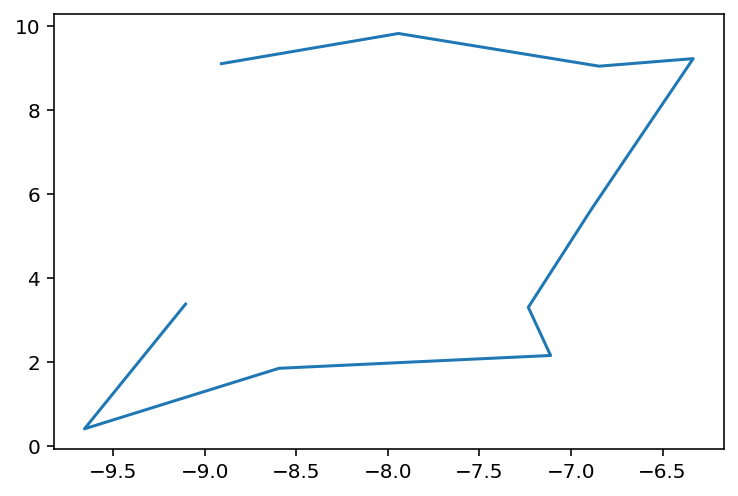

In [2]:
Nt = 10 ## number of measured positions from bear's trackinkg collar
sigma_obs = 0.2
sigma = 2.

X0true = -25. + 50.*rand(1, 2) ## bear's initial position
Xtrue = X0true + normal(0, sigma, [Nt, 2]).cumsum(axis=0)
Z = Xtrue + normal(0, sigma_obs, [Nt, 2]) ## add observation error to the path
plot(Z[:, 0], Z[:, 1]);

In [3]:
Nsteps = 50
N_burn_in = Nsteps
Nchains = 2


Sigma_obs = sigma_obs*tf.ones([1, 1, 2], dtype=tf.float64)
Sigma = sigma*tf.ones([1, 1, 2], dtype=tf.float64)
Sigma_x0 = 100*tf.ones([1, 2], dtype=tf.float64)
def log_target_density(Xfull):
    ## X : [parallel chains, time, space]
    X0 = Xfull[:, 0, :]
    X = Xfull[:, 1:, :] ## same shape as `Z`
    ## observation likelihood: density for Z given X
    G = tfd.MultivariateNormalDiag(
        loc=X, 
        scale_diag=Sigma_obs)
    logG = tf.reduce_sum(
        G.unnormalized_log_prob(Z),
        axis=1)
    ## motion model: density for X
    F = tfd.MultivariateNormalDiag(
        loc=Xfull[:, :-1, :], 
        scale_diag=Sigma)
    logF = tf.reduce_sum(
        F.unnormalized_log_prob(X),
        axis=1)
    ## initial position prior: density for X0
    F0 = tfd.MultivariateNormalDiag(
        loc=tf.zeros([1, 2], dtype=tf.float64), 
        scale_diag=Sigma_x0)
    logF0 = F0.unnormalized_log_prob(X0)
    return logG + logF + logF0

@tf.function()
def track_sampler(Xinit):
    #def trace_everything(states, previous_kernel_results):
    #    return previous_kernel_results
    
    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=log_target_density,
        max_tree_depth=8,
        max_energy_diff=1000,
        step_size=tf.cast(0.1, tf.float64))

    # kernel = tfp.mcmc.HamiltonianMonteCarlo(
    #     target_log_prob_fn=log_target_density,
    #     num_leapfrog_steps=10,
    #     step_size=tf.cast(0.1, tf.float64))
    

    adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8 * N_burn_in),
        target_accept_prob=tf.cast(0.7, tf.float64))
    
    Xchain = tfp.mcmc.sample_chain(
        num_results=Nsteps,
        num_burnin_steps=N_burn_in,
        current_state=Xinit,
        #trace_fn=trace_everything,
        trace_fn=None,
        kernel=adaptive_kernel,
        parallel_iterations=4)
    return Xchain

Xinit = zeros([Nchains, Nt+1, 2])
Xinit[:, 0, :] = normal(0, 25., [Nchains, 2])
Xinit[:, 1:, :] = Z + normal(0, 5., [Nchains, Nt, 2])
Xchain = track_sampler(Xinit)
Xchain = array(Xchain)

@tf.function()
def track_sampler(Xinit):
    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=log_target_density,
        max_tree_depth=8,
        max_energy_diff=1000,
        step_size=tf.cast(0.1, tf.float64))

    adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8 * N_burn_in),
        target_accept_prob=tf.cast(0.7, tf.float64))
    
    Xchain = tfp.mcmc.sample_chain(
        num_results=Nsteps,
        num_burnin_steps=N_burn_in,
        current_state=Xinit,
        #trace_fn=trace_everything,
        trace_fn=None,
        kernel=adaptive_kernel,
        parallel_iterations=4)
    return Xchain

Xinit = zeros([Nchains, Nt+1, 2])
Xinit[:, 0, :] = normal(0, 25., [Nchains, 2])
Xinit[:, 1:, :] = Z + normal(0, 5., [Nchains, Nt, 2])
Xchain = track_sampler(Xinit)
Xchain = array(Xchain)

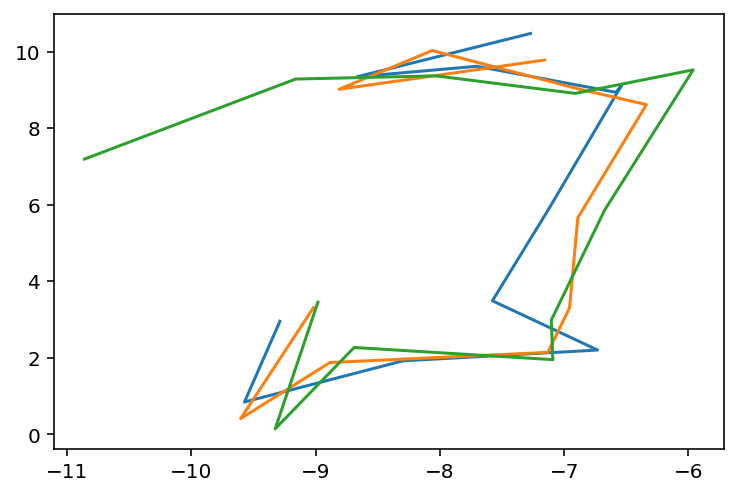

In [4]:
plot(Xchain[-1, 0, :, 0], Xchain[-1, 0, :, 1])
plot(Xchain[-2, 0, :, 0], Xchain[-2, 0, :, 1])
plot(Xchain[-10, 0, :, 0], Xchain[-10, 0, :, 1])

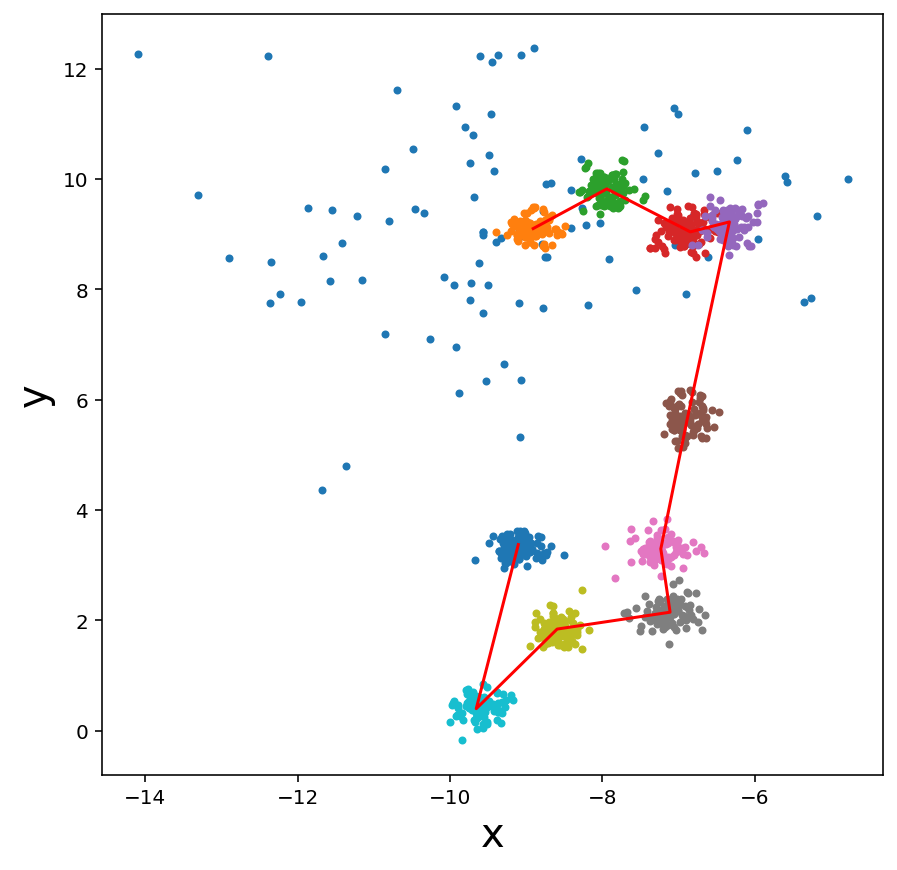

In [5]:
figure(1, [7, 7])
## Xchain: [mcmc steps, parallel chains, time, space]
plot(Xchain[..., 0].reshape(-1, Nt+1), Xchain[..., 1].reshape(-1, Nt+1), '.')
plot(Z[:, 0], Z[:, 1], 'r')
xlabel('x', fontsize=20)
ylabel('y', fontsize=20);

# Suppose we want to sample $X$ at times that are in between the observation times

In [6]:
Nt = 100
sigma_subsample = sigma/sqrt(10)

Zpadded = zeros([Nt, 2])
Zpadded[::10] = Z
### where Z is zero, we will modify our model so that these values of Z have no effect

## this is an indicator variable for when we have measured positions
CHI_observed = zeros([Nt]) 
CHI_observed[::10] = 1.

In [7]:
Nsteps = 50
N_burn_in = Nsteps
Nchains = 5


Sigma_obs = sigma_obs*tf.ones([1, 1, 2], dtype=tf.float64)
Sigma = sigma_subsample*tf.ones([1, 1, 2], dtype=tf.float64)
Sigma_x0 = 100*tf.ones([1, 2], dtype=tf.float64)
def log_target_density(Xfull):
    ## X : [parallel chains, time, space]
    X0 = Xfull[:, 0, :]
    X = Xfull[:, 1:, :] ## same shape as `Z`
    ## observation likelihood: density for Z given X
    G = tfd.MultivariateNormalDiag(
        loc=X, 
        scale_diag=Sigma_obs)
    logG = tf.reduce_sum(
        CHI_observed[None, :]*G.unnormalized_log_prob(Zpadded),
        axis=1)
    ## motion model: density for X
    F = tfd.MultivariateNormalDiag(
        loc=Xfull[:, :-1, :], 
        scale_diag=Sigma)
    logF = tf.reduce_sum(
        F.unnormalized_log_prob(X),
        axis=1)
    ## initial position prior: density for X0
    F0 = tfd.MultivariateNormalDiag(
        loc=tf.zeros([1, 2], dtype=tf.float64), 
        scale_diag=Sigma_x0)
    logF0 = F0.unnormalized_log_prob(X0)
    return logG + logF + logF0

@tf.function()
def track_sampler(Xinit):
    ## We are sampling a distribution over 200 dimensions
    
    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=log_target_density,
        max_tree_depth=8,
        max_energy_diff=1000,
        step_size=tf.cast(0.1, tf.float64))

    # kernel = tfp.mcmc.HamiltonianMonteCarlo(
    #     target_log_prob_fn=log_target_density,
    #     num_leapfrog_steps=10,
    #     step_size=tf.cast(0.1, tf.float64))
    

    adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8 * N_burn_in),
        target_accept_prob=tf.cast(0.7, tf.float64))
    
    Xchain = tfp.mcmc.sample_chain(
        num_results=Nsteps,
        num_burnin_steps=N_burn_in,
        current_state=Xinit,
        #trace_fn=trace_everything,
        trace_fn=None,
        kernel=adaptive_kernel,
        parallel_iterations=4)
    return Xchain

Xinit = zeros([Nchains, Nt+1, 2])
Xinit[:, 0, :] = normal(0, 25., [Nchains, 2])
Xinit[:, 1:, :] = Zpadded + normal(0, 5., [Nchains, Nt, 2])
Xchain = track_sampler(Xinit)
Xchain = array(Xchain)

### This plot shows the MCMC result as a time series of marginal distributions for the position at time $t$

In [8]:
xmin = Xchain.min()
xmax = Xchain.max()
@interact(t=(0, Nt, 1))
def pfun(t=0):
    fig = figure(1, [7, 7])
    plot(Xchain[:, :, t, 0], Xchain[:, :, t, 1], 'r.', ms=2)
    if t > 0 and CHI_observed[t-1] == 1:
        plot(Zpadded[t-1, 0], Zpadded[t-1, 1], 'ko', mfc='none', ms=25)
    xlim(xmin, xmax)
    ylim(xmin, xmax)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$y$', fontsize=24)

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

### This shows the MCMC result as a collection of sample trajectories
Each parallel chain (at a given step) represents an independent path $X_{0:T}$. Here each is shown as a different color.

In [9]:
xmin = Xchain.min()
xmax = Xchain.max()
@interact(t=(0, Nt, 1))
def pfun(t=0):
    fig = figure(1, [7, 7])
    for i in arange(5):
        plot(Xchain[-1, i, t, 0], Xchain[-1, i, t, 1], '.', ms=10)
    if t > 0 and CHI_observed[t-1] == 1:
        plot(Zpadded[t-1, 0], Zpadded[t-1, 1], 'ko', mfc='none', ms=25)
    xlim(xmin, xmax)
    ylim(xmin, xmax)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$y$', fontsize=24)

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

# Expectation Maximization Algorithm
We want to compute the log likelihood $\mathcal{L}(\theta)$ of the parameters $\theta$ so that we can obtain the maximum likelihood estimator
  $$\theta_{MLE} =  \text{arg max}_{\theta}\mathcal{L}(\theta).$$




  1. E-step: given fixed parameters $\theta_j$ sample
  $$ X_{1:T} \mid z_{1:T}, \theta_j$$
  Then plug them into the log generative density and average over the samples. This appproximates the expectation,
  \begin{align}
  Q(\theta | \theta_j) &= E[\log(\prod_{k=1}^{T}g(z_k| X_k, \theta)f(X_k | X_{k-1}, \theta)p_0(X_0|\theta)) \mid \theta_j]\\
  &= E[\sum_{k=1}^{T}\log(g(z_k| X_k, \theta)) + \sum_{k=1}^{T}\log(f(X_k | X_{k-1}, \theta)) + \log(p_0(X_0|\theta)) \mid \theta_j]
  \end{align}
  2. M-step: compute $$\theta_{j+1} = \text{arg max}_{\theta} Q(\theta | \theta_j)  $$
  
Repeat these steps until convergence is reached.

## Note the following:
The averaged generative density
$$L(\theta) = \int_{R}\cdots \int_{R}\prod_{k=1}^{T}g(z_k| x_k)f(x_k | x_{k-1})p_0(x_0) \,dx_0\cdots dx_T $$
is not the same as the averaged log generative density
$$L(\theta) = \int_{R}\cdots \int_{R}\log(\prod_{k=1}^{T}g(z_k| x_k)f(x_k | x_{k-1})p_0(x_0)) \,dx_0\cdots dx_T $$
$$= \int_{R}\cdots \int_{R}\sum_{k=1}^{T}\left[\log(g(z_k| x_k)) + \log(f(x_k | x_{k-1})) + \log(p_0(x_0)) \right] \,dx_0\cdots dx_T $$

# Expectation Maximization with Tensorflow gradient descent
Suppose we want to estimate the bear's mobility parameter $\sigma$

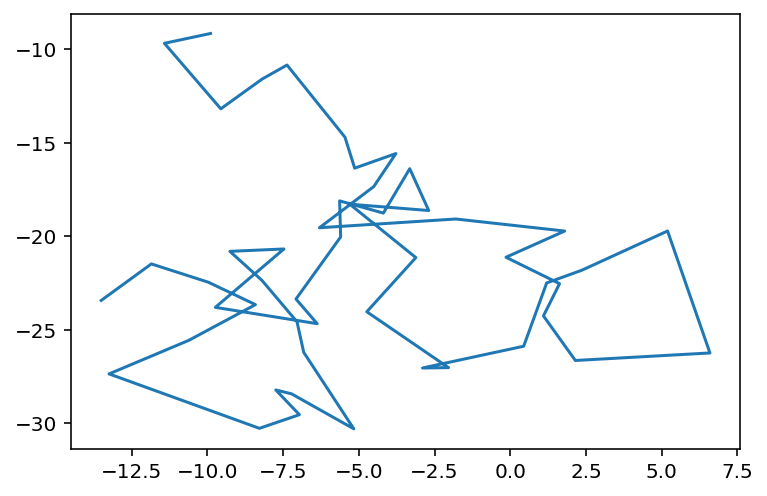

In [10]:
Nt = 50 ## number of measured positions from bear's trackinkg collar
sigma_obs = 0.2
sigma = 2.

X0true = -25. + 50.*rand(1, 2) ## bear's initial position
Xtrue = X0true + normal(0, sigma, [Nt, 2]).cumsum(axis=0)
Z = Xtrue + normal(0, sigma_obs, [Nt, 2]) ## add observation error to the path
plot(Z[:, 0], Z[:, 1]);

In [11]:
Nsteps = 10 ## number of MCMC steps
N_burn_in = 50
Nchains = 8

log_sigma_obs = tf.Variable(log(1.), dtype=tf.float64)
log_sigma = tf.Variable(log(5.), dtype=tf.float64)

@tf.function()
def log_target_density(Xfull):
    ## Xfull must be a three dimensional array 
    Sigma_obs = tf.math.exp(log_sigma_obs)*tf.ones([1, 1, 2], dtype=tf.float64)
    ## tensorflow variable appears here
    Sigma = tf.math.exp(log_sigma)*tf.ones([1, 1, 2], dtype=tf.float64) 
    Sigma_x0 = 100*tf.ones([1, 2], dtype=tf.float64)
    ## X : [parallel chains, time, space]
    X0 = Xfull[:, 0, :]
    X = Xfull[:, 1:, :] ## same shape as `Z`
    ## observation likelihood: density for Z given X
    G = tfd.MultivariateNormalDiag(
        loc=X, 
        scale_diag=Sigma_obs)
    logG = tf.reduce_sum(
        G.unnormalized_log_prob(Z),
        axis=1)
    ## motion model: density for X
    F = tfd.MultivariateNormalDiag(
        loc=Xfull[:, :-1, :], 
        scale_diag=Sigma)
    logF = tf.reduce_sum(
        F.unnormalized_log_prob(X),
        axis=1)
    ## initial position prior: density for X0
    F0 = tfd.MultivariateNormalDiag(
        loc=tf.zeros([1, 2], dtype=tf.float64), 
        scale_diag=Sigma_x0)
    logF0 = F0.unnormalized_log_prob(X0)
    return logG + logF + logF0


In [12]:
## Estep

def Estep():
    Xinit = zeros([Nchains, Nt+1, 2])
    Xinit[:, 0, :] = normal(0, 25., [Nchains, 2])
    Xinit[:, 1:, :] = Z + normal(0, 5., [Nchains, Nt, 2])
    Xchain = track_sampler(Xinit)
    Xchain = array(Xchain)
    return Xchain ## [MCMC steps, parallel chains, time, space]
@tf.function()
def averaged_log_density():
    return tf.reduce_mean(log_target_density(Xchain.reshape(-1, Nt+1, 2)))

In [13]:
## M step

N_gd_steps = 10
learning_rate = 0.001
optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
# learning_rate = 0.01
# optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

trainable_variables = [log_sigma, log_sigma_obs]
@tf.function()
def Mstep(Xchain):
    loss = tf.constant(0., dtype=tf.float64)
    for _ in tf.range(N_gd_steps):
        with tf.GradientTape() as tape:
            ## must tell Tensorflow what trainable variables to use for 
            ## gradients
            tape.watch(trainable_variables)
            ## we use the negative averaged log likelihood because our 
            ## optimizer is set up to solve mimimization
            loss = -averaged_log_density()
        ## compute the gradient of the loss
        grad = tape.gradient(loss, trainable_variables)
        ## this takes one step of gradient descent to change the trainable 
        ## prameters
        optimizer.apply_gradients( 
            zip(grad, trainable_variables))
        ## Note that the values stored in the trainable variable object changes 
        ## as a result of this operation
    return loss

In [14]:
log_sigma.assign(log(4.)), log_sigma_obs.assign(log(0.1))
print('sigma:', exp(log_sigma), 'sigma_obs:', exp(log_sigma_obs))
for _ in arange(10):
    Xchain = Estep()
    loss = Mstep(Xchain)
    print('loss:', array(loss))
    print('sigma:', exp(log_sigma), 'sigma_obs:', exp(log_sigma_obs))

sigma: 4.0 sigma_obs: 0.10000000000000002
loss: 145.12796854786822
sigma: 2.4445825168491893 sigma_obs: 0.1017857692456935
loss: 142.91076417645894
sigma: 2.179557317590686 sigma_obs: 0.10197472640372933
loss: 142.8707967804711
sigma: 2.1481820128359796 sigma_obs: 0.10199498430431819
loss: 142.87030859202727
sigma: 2.144772179401029 sigma_obs: 0.10199715912077027
loss: 142.8703029277471
sigma: 2.1444055678398897 sigma_obs: 0.10199739263574566
loss: 142.87030286239778
sigma: 2.1443661976384725 sigma_obs: 0.10199741770917452
loss: 142.8703028616443
sigma: 2.144361970231327 sigma_obs: 0.1019974204014126
loss: 142.8703028616356
sigma: 2.14436151631625 sigma_obs: 0.10199742069048948
loss: 142.87030286163548
sigma: 2.144361467577488 sigma_obs: 0.10199742072152876
loss: 142.8703028616355
sigma: 2.1443614623442038 sigma_obs: 0.10199742072486163
